In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob

# Get DATA

In [3]:
label_name={'glioma_tumor':0, 'meningioma_tumor':1,'no_tumor':2,'pituitary_tumor':3}

In [4]:
print(label_name.keys())

dict_keys(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])


In [5]:
image_size=128

In [6]:
Test_image_path='/content/drive/MyDrive/kaggle/Tumor brain classification/Testing/'
Train_image_path='/content/drive/MyDrive/kaggle/Tumor brain classification/Training/'

In [7]:
all_image=[]
all_label=[]

for label in label_name.keys():
    for path in tqdm(glob(f'{Test_image_path+label}/*.jpg')):
        img=cv2.imread(path)
        img=cv2.resize(img,(image_size, image_size))
        all_image.append(img)
        all_label.append(label)

100%|██████████| 74/74 [00:23<00:00,  3.14it/s]


In [8]:
for label in label_name.keys():
    for path in tqdm(glob(f'{Train_image_path+label}/*.jpg')):
        img=cv2.imread(path)
        img=cv2.resize(img,(image_size, image_size))
        all_image.append(img)
        all_label.append(label)

100%|██████████| 827/827 [00:13<00:00, 60.09it/s] 


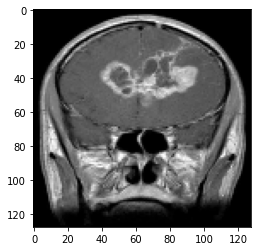

In [9]:
plt.imshow(all_image[0])

In [10]:
all_label[0]

'glioma_tumor'

# Split Train and Test set

In [11]:
X_train, X_test, y_train, y_test=train_test_split(all_image, all_label, random_state=42, train_size=0.8)

In [12]:
X_train, X_valid, y_train, y_valid=train_test_split(X_train, y_train, random_state=42, train_size=0.8)

In [13]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_valid))
print(len(y_valid))

2088
2088
653
653
523
523


In [14]:
X_train=np.array(X_train)
X_test=np.array(X_test)
X_valid=np.array(X_valid)

In [15]:
y_train[0]

'meningioma_tumor'

In [16]:
y_train_new = []
for i in y_train:
    y_train_new.append(label_name[i])
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(label_name[i])
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

y_valid_new = []
for i in y_valid:
    y_valid_new.append(label_name[i])
y_valid = y_valid_new
y_valid = tf.keras.utils.to_categorical(y_valid)

In [17]:
y_train

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

In [18]:
y_test

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [19]:
y_valid

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [20]:
X_train

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
        

# select model (Transfer learning) - EfficientNetB0

In [21]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16719872/16705208 [==============================] - 0s 0us/step


### 평균 풀링 사용

In [22]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 129, 129, 3)  0           ['normalization[0][0]']      

In [24]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [25]:
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

In [26]:
history=model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=1, batch_size=16, callbacks=[checkpoint])

Epoch 1/20
131/131 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7754
Epoch 1: val_accuracy improved from -inf to 0.82983, saving model to effnet.h5
131/131 [==============================] - 34s 93ms/step - loss: 0.6079 - accuracy: 0.7754 - val_loss: 0.7103 - val_accuracy: 0.8298
Epoch 2/20
131/131 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8980
Epoch 2: val_accuracy improved from 0.82983 to 0.89675, saving model to effnet.h5
131/131 [==============================] - 10s 74ms/step - loss: 0.3007 - accuracy: 0.8980 - val_loss: 0.3655 - val_accuracy: 0.8967
Epoch 3/20
131/131 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9397
Epoch 3: val_accuracy improved from 0.89675 to 0.91587, saving model to effnet.h5
131/131 [==============================] - 10s 75ms/step - loss: 0.1839 - accuracy: 0.9397 - val_loss: 0.3173 - val_accuracy: 0.9159
Epoch 4/20
131/131 [==============================] - ETA: 0s - loss: 

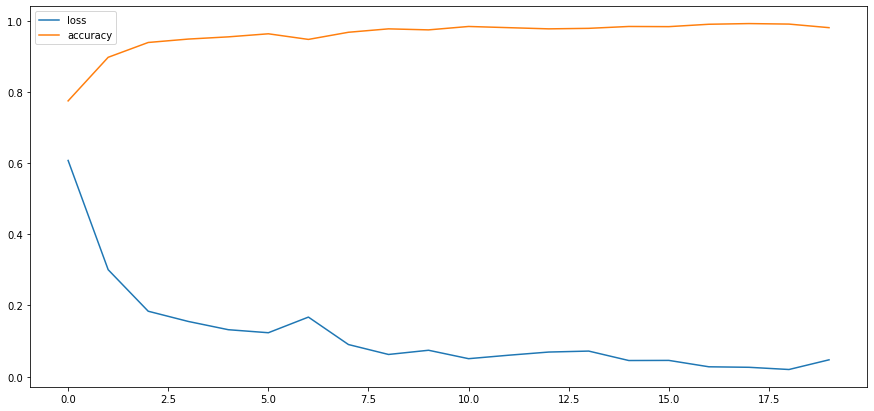

In [27]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

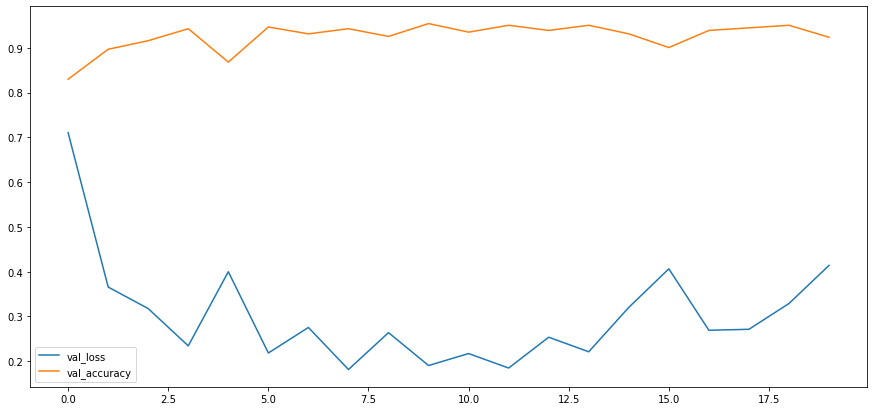

In [28]:
plt.figure(figsize=(15,7))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [29]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [31]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       195
           1       0.87      0.94      0.90       185
           2       0.96      0.97      0.96        94
           3       0.94      0.98      0.96       179

    accuracy                           0.93       653
   macro avg       0.93      0.93      0.93       653
weighted avg       0.93      0.93      0.93       653

